In [18]:
from sklearn.datasets import make_multilabel_classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import numpy as np
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle


label_encoder = LabelEncoder()



In [19]:

class MultiLabelClassifier:
    def __init__(self, classifier):
        self.classifier = classifier
        self.ova_classifier = None
        self.pca = None
        self.poly = None
        self.best_estimator = None
        self.num_classes = 9
        self.all_fpr = []
        self.all_tpr = []
        self.all_auc = []

    def train(self, X, y, n_components=None, degree=None):
        if n_components is not None:
            self.pca = PCA(n_components=n_components)
            X = self.pca.fit_transform(X)
        
        if degree is not None:
            self.poly = PolynomialFeatures(degree=degree)
            X = self.poly.fit_transform(X)
        
        self.ova_classifier = OneVsRestClassifier(self.classifier)
        self.ova_classifier.fit(X, y)
        
        self.best_estimator = self.ova_classifier

    def grid_search(self, X, y, parameter_grid, scoring_metric, n_components=None, degree=None):
        if n_components is not None:
            self.pca = PCA(n_components=n_components)
            X = self.pca.fit_transform(X)
        
        if degree is not None:
            self.poly = PolynomialFeatures(degree=degree)
            X = self.poly.fit_transform(X)
        
        scorer = make_scorer(scoring_metric)
        grid_search = GridSearchCV(self.ova_classifier, parameter_grid, scoring=scorer, cv=10, verbose=10)
        grid_search.fit(X, y)
        
        self.best_estimator = grid_search.best_estimator_
        
        # Predict the y values using the best estimator
        y_pred = self.best_estimator.predict(X)
        
        # Perform majority voting (hard voting)
        y_pred_majority = np.array([np.argmax(pred) for pred in y_pred.T])
        
        return grid_search.best_params_, grid_search.best_score_, y_pred_majority

    def predict(self, X, n_components=None, degree=None):
        if n_components is not None:
            X = self.pca.transform(X)
        
        if degree is not None:
            X = self.poly.transform(X)
        
        return self.best_estimator.predict(X)
    
    def compute_roc_curve(self, y_true, y_scores):
        # Convert y_true to one-hot encoded format
        y_true_one_hot = label_binarize(y_true, classes=np.arange(self.num_classes))
        
        # Compute fpr, tpr, and thresholds for each label
        for label_index in range(self.num_classes):
            # Extract the predicted labels for the current label
            predicted_labels = y_scores == label_index
            
            # Compute fpr, tpr, and thresholds for the current label
            fpr, tpr, thresholds = roc_curve(y_true_one_hot[:, label_index], predicted_labels)
            
            # Compute the area under the ROC curve (AUC) for the current label
            roc_auc = auc(fpr, tpr)
            
            # Store the fpr, tpr, and auc for the current label
            self.all_fpr.append(fpr)
            self.all_tpr.append(tpr)
            self.all_auc.append(roc_auc)

    
    def plot_roc_curve(self):
        # Plot the ROC curve for each class
        plt.figure(figsize=(10, 6))
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Customize colors for each class
        for class_index in range(self.num_classes):
            plt.plot(self.all_fpr[class_index], self.all_tpr[class_index], color=colors[class_index], 
                     label='Class {0} (AUC = {1:.2f})'.format(class_index, self.all_auc[class_index]))
    
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for reference
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - Multiclass Classification')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()


In [20]:
data = pd.read_csv('../out/features_selected/breakhis_selected_features_train.csv',header=None)
# data = data.sample(
#     frac=1,
#     random_state=42
# )

X_train = data.iloc[:, :-1]  # Exclude the last column (Y)
Y_train = data.iloc[:, -1]


Y_tr_encoded = label_encoder.fit_transform(Y_train)
Y_tr = Y_tr_encoded.reshape(-1, 1)
print(Y_tr.shape, Y_tr.dtype)

data = pd.read_csv('../out/features_selected/breakhis_selected_features_validation.csv',header=None)
# data = data.sample(
#     frac=1,
#     random_state=42
# )

X_validation = data.iloc[:, :-1]  # Exclude the last column (Y)
Y_validation = data.iloc[:, -1]

Y_val_encoded = label_encoder.fit_transform(Y_validation)
Y_val = Y_val_encoded.reshape(-1, 1)

data = pd.read_csv('../out/features_selected/breakhis_selected_features_test.csv',header=None)
# data = data.sample(
#     frac=1,
#     random_state=42
# )

X_test = data.iloc[:, :-1]  # Exclude the last column (Y)
Y_test = data.iloc[:, -1]


Y_t_encoded = label_encoder.fit_transform(Y_test)
Y_t = Y_val_encoded.reshape(-1, 1)


(995, 1) int64


In [21]:
print(Y_tr)
print(Y_tr.dtype)

# print(X_train.iloc[:, -1:])

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]


In [22]:
# Step 2: Define the classifiers and parameter grids
classifier_rf = RandomForestClassifier()
classifier_svm = SVC()
classifier_knn = KNeighborsClassifier()

parameter_grid_rf = {'estimator__n_estimators': [100, 200, 300], 'estimator__max_depth': [None, 5, 10]}
parameter_grid_svm = {'estimator__C': [0.1, 1, 10], 'estimator__kernel': ['linear', 'rbf']}
parameter_grid_knn = {'estimator__n_neighbors': [3,4,5, 7], 'estimator__weights': ['uniform', 'distance']}

# Step 3: Create an instance of the MultiLabelClassifier with each classifier
multi_label_classifier_rf = MultiLabelClassifier(classifier_rf)
multi_label_classifier_svm = MultiLabelClassifier(classifier_svm)
multi_label_classifier_knn = MultiLabelClassifier(classifier_knn)

components = None
degree = None

# Step 4: Train each MultiLabelClassifier
multi_label_classifier_rf.train(X_train, Y_tr,components,degree)
multi_label_classifier_svm.train(X_train, Y_tr,components,degree)
multi_label_classifier_knn.train(X_train, Y_tr,components,degree)

# Step 5: Perform grid search using each MultiLabelClassifier
best_params_rf, best_score_rf, y_pred_majority_rf = multi_label_classifier_rf.grid_search(X_validation, Y_val, parameter_grid_rf, accuracy_score,components,degree)
best_params_svm, best_score_svm, y_pred_majority_svm = multi_label_classifier_svm.grid_search(X_validation, Y_val, parameter_grid_svm, accuracy_score,components,degree)
best_params_knn, best_score_knn, y_pred_majority_knn = multi_label_classifier_knn.grid_search(X_validation, Y_val, parameter_grid_knn, accuracy_score,components,degree)


Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV 1/10; 1/9] START estimator__max_depth=None, estimator__n_estimators=100.....
[CV 1/10; 1/9] END estimator__max_depth=None, estimator__n_estimators=100;, score=0.500 total time=   3.0s
[CV 2/10; 1/9] START estimator__max_depth=None, estimator__n_estimators=100.....
[CV 2/10; 1/9] END estimator__max_depth=None, estimator__n_estimators=100;, score=0.480 total time=   2.9s
[CV 3/10; 1/9] START estimator__max_depth=None, estimator__n_estimators=100.....
[CV 3/10; 1/9] END estimator__max_depth=None, estimator__n_estimators=100;, score=0.540 total time=   2.7s
[CV 4/10; 1/9] START estimator__max_depth=None, estimator__n_estimators=100.....
[CV 4/10; 1/9] END estimator__max_depth=None, estimator__n_estimators=100;, score=0.440 total time=   2.6s
[CV 5/10; 1/9] START estimator__max_depth=None, estimator__n_estimators=100.....
[CV 5/10; 1/9] END estimator__max_depth=None, estimator__n_estimators=100;, score=0.450 total time=   2.5s

In [23]:
# Step 6: Print the best parameters, their corresponding scores, and the predicted y values using majority voting for each classifier
print("Random Forest - Best Parameters: ", best_params_rf)
print("Random Forest - Best Score: ", best_score_rf)
print()
print("SVM - Best Parameters: ", best_params_svm)
print("SVM - Best Score: ", best_score_svm)
print()
print("K-Nearest Neighbors - Best Parameters: ", best_params_knn)
print("K-Nearest Neighbors - Best Score: ", best_score_knn)

Random Forest - Best Parameters:  {'estimator__max_depth': None, 'estimator__n_estimators': 200}
Random Forest - Best Score:  0.5227373737373737

SVM - Best Parameters:  {'estimator__C': 1, 'estimator__kernel': 'rbf'}
SVM - Best Score:  0.5618383838383838

K-Nearest Neighbors - Best Parameters:  {'estimator__n_neighbors': 5, 'estimator__weights': 'distance'}
K-Nearest Neighbors - Best Score:  0.48545454545454547


In [24]:
rf_prediction = multi_label_classifier_rf.predict(X_test)
SVM_predict = multi_label_classifier_svm.predict(X_test)
KNN_predict = multi_label_classifier_knn.predict(X_test)
print(rf_prediction)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 2 2 2 

In [56]:
rf_proba  = multi_label_classifier_rf.best_estimator.predict_proba(X_test)

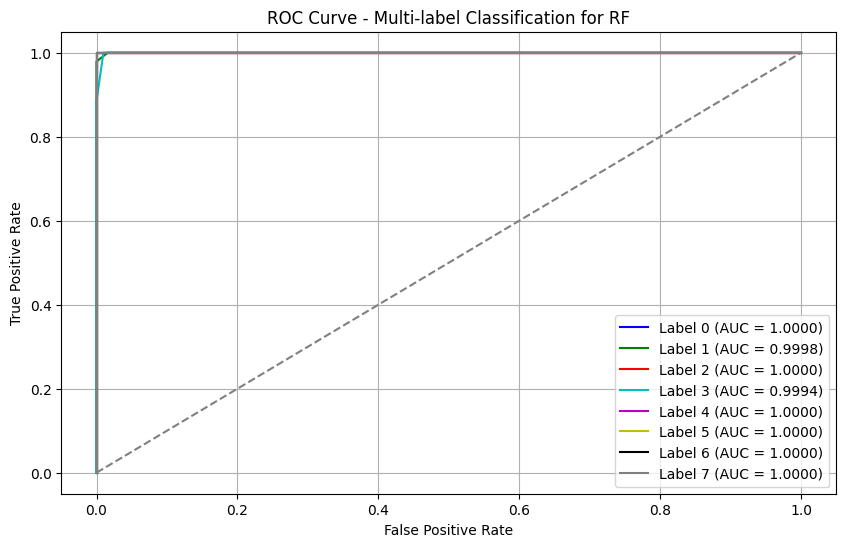

In [57]:
def compute_roc_curve_proba(y_true, y_proba, model_name):
    all_fpr = []
    all_tpr = []
    all_auc = []

    # Convert y_true to one-hot encoded format
    y_true_one_hot = label_binarize(y_true, classes=np.arange(8))
    
    # Compute fpr, tpr, and thresholds for each label
    for label_index in range(8):
        # Extract the predicted labels for the current label
        #predicted_labels = (y_scores == label_index).astype(int)
        
        # Compute fpr, tpr, and thresholds for the current label
        fpr, tpr, _ = roc_curve(y_true_one_hot[:, label_index], y_proba[:, label_index])
        
        # Compute the area under the ROC curve (AUC) for the current label
        roc_auc = auc(fpr, tpr)
        
        # Store the fpr, tpr, and auc for the current label
        all_fpr.append(fpr)
        all_tpr.append(tpr)
        all_auc.append(roc_auc)

    # Plot the ROC curves
    plt.figure(figsize=(10, 6))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'gray']  # Customize colors for each label
    for label_index in range(8):
        plt.plot(all_fpr[label_index], all_tpr[label_index], color=colors[label_index],
                 label='Label {0} (AUC = {1:.4f})'.format(label_index, all_auc[label_index]))

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for reference
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Multi-label Classification for {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Assuming rf_prediction contains the predicted labels from multi_label_classifier_rf.predict
compute_roc_curve_proba(Y_t, rf_proba, 'RF')

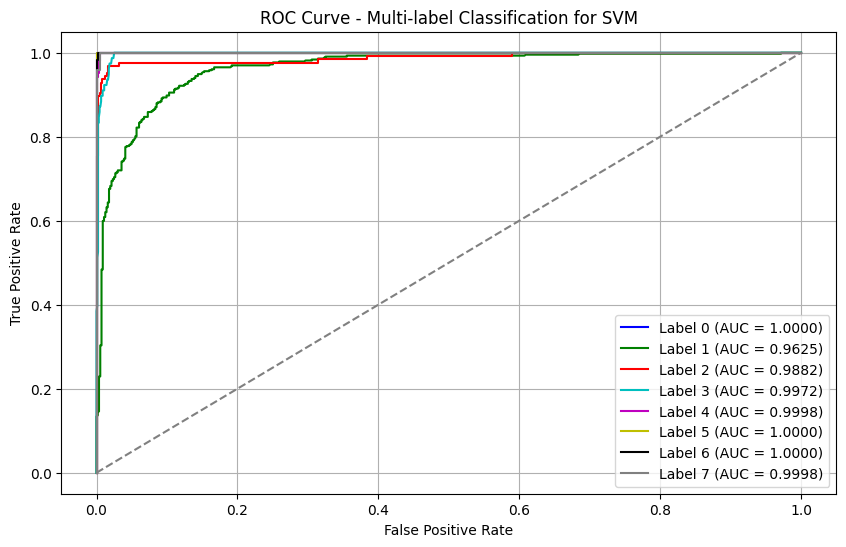

In [58]:
svm_proba = multi_label_classifier_svm.best_estimator.decision_function(X_test)
compute_roc_curve_proba(Y_t, svm_proba, 'SVM')

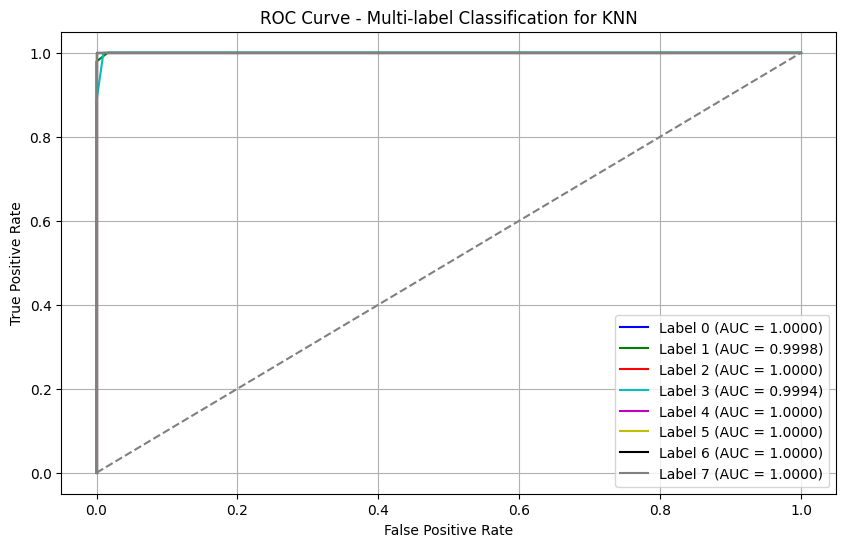

In [59]:
knn_proba = multi_label_classifier_knn.best_estimator.predict_proba(X_test)
compute_roc_curve_proba(Y_t, knn_proba, 'KNN')